# Projekt Data Analytics
## Przewidywanie i analiza stanu cywilnego ludności USA na przestrzeni lat 

Autorzy: Julia Nowak, Adam Złocki

### 1. Sformuowanie problemu


##### Główny problem
Celem projektu jest predykcja ilości dorosłych osób po ślubie, rozwiedzionych oraz takich, które nigdy nie brały ślubu w społeczeństwie USA.
Problem nie skupia się na konkretnych rasach ludzi – przyjęte zostały dane ogólne,
wspólne dla wszystkich ras. Dobrany zestaw danych umożliwia jednak podzielenie danych na konkretne rasy oraz odrębną analizę stanu cywilnego. Idea projektu została oparta o aktualny temat dotyczący hipotetycznego spadku liczby małżeństw oraz wzrostu liczby rozwodów
w krajach wysoko rozwiniętych, takich jak USA. Podczas analizy chcemy wykazać istniejące trendy oraz przewidzieć rozkład interesujących nas wartości w przyszłości.

##### Przykłady użycia i powody analizy
Problem predykcji stanu cywilnego oraz przewidywanie ilości m.in. małżeństw
w społeczeństwie jest z punktu widzenia państwa niezwykle istotną informacją.
Jest to problem, który warto analizować chociażby pod kątem planowania przez rząd Stanów Zjednoczonych polityki prorodzinnej. Temat jest istotny także przy wszelkiego rodzaju oszacowaniach związanych z przyrostem naturalnym czy uwarunkowaniami społecznymi. Analiza może wskazać rządowi ze znacznym wyprzedzeniem, iż w społeczeństwie zachodzą pewne zmiany, które warto wziąć pod uwagę przy tworzeniu przyszłych planów.

##### Pochodzenie i zawartość danych
Dane, które są przez nas wykorzystywane, pochodzą z oficjalnej strony rządowej USA (www.census.gov). Zawierają one informacje o liczbie osób o danym stanie cywilnym w zależności od roku, średnim wieku zawarcia pierwszego małżeństwa, ilości dostępnych na rynku mieszkań oraz o całkowitym, średnim przychodzie na członka gospodarstwa domowego w celu zaprezentowania ogólnej sytuacji materialnej społeczeństwa.
Dodatkowo dostępne są również identyczne dane z uwzględnieniem podziału na rasy,
a więc możliwe jest przeprowadzenie predykcji dla każdej z nich osobno, a następnie wykonanie analizy porównawczej, jednak nie zastosowaliśmy takiego podejścia.
Wykorzystywane przez nas dane są danymi historycznymi, uzupełnianymi od XX wieku do 2023 roku. Ich ostatnia aktualizacja miała miejsce w listopadzie 2023 roku – są to więc dane stosunkowo świeże. Do analizy przyjęte zostały lata 2020 – 2022, z pominięciem duplikatów niektórych lat (z każdej pary wybrano dane odświeżone).
Dane uwzględniają różne tabele pochodzące z Ankiet Obecnej Populacji (ang. Current Population Survey; CPS), przeprowadzanych co roku przez cenzus w USA.

##### Schemat DAG
Poniższy diagram DAG reprezentuje wykorzystane przez nas w projekcie zależności. Jako predyktory zastosowaliśmy średni przychód na członka gospodarstwa domowego, oraz ilość dostępnych na rynku mieszkań, dzięki czemu badaliśmy wpływ ogólnej sytuacji ekonomicznej społeczeństwa na ilość małżeństw.


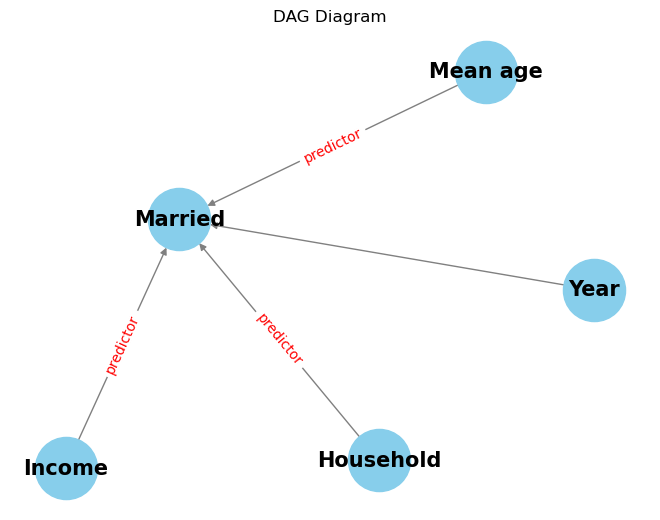

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Year")
G.add_node("Household")
G.add_node("Income")
G.add_node("Married")
G.add_node("Mean age")

# Add edges
G.add_edge("Year", "Married")
G.add_edge("Income", "Married")
G.add_edge("Household", "Married")
G.add_edge("Mean age", "Married")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=15, font_weight='bold')

# Add edge labels
edge_labels = {
    ("Income", "Married"): "predictor",
    ("Household", "Married"): "predictor",
    ("Mean age", "Married"): "predictor"
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("DAG Diagram")
plt.show()


### 2. Preprocessing - wstępne przetwarzanie danych

1. Wybranie analizowanych lat oraz rasy:
- wybrano lata 1993 - 2022 (prawie 30 lat do analizy)
- lata 2018-2023 zostały przeznaczone do oceny działania modelu
- skupiono się na analizie ogólnej wszystkich ras łącznie

2. Uwagi do danych:
- w przypadku lat 2011 oraz 2021 w danych wystąpiły podwójne wyniki, ze względu na to, iż zaprezentowano wyniki pierwotne oraz zaktualizowane na podstawie populacji z ostatniego spisu powszechnego co dziesięciolecie (przyjęto zaktualizowane wartości)
- w roku 2014 nastąpiła zmiana pytań odnośnie przychodu, a więc część pytań zadanych ankietowanym się różniła
- od 2019 uwzględniono również małżeństwa homoseksualne

3. Usuwanie i operacje:
- Rok zmieniono z "..2011" do formy bez kropek
- usunięto rok 2023 ze względu na przychód z lat poprzednich
- usunięto zduplikowane lata
- połączono dane tak, aby pominąć kwestię płci
- wyliczono całość badanych (z uzględnieniem danych spoza analizowanych)
- household wybrano z odrębnej bazy danych dla lepszych wyników
- przekształcenie lat na liczby, ujednolicenie typów danych


##### Import niezbędnych bibliotek

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns


In [8]:
df = pd.read_excel("data.xlsx", sheet_name="Raw_data")
df = df[['Year', 'Married', 'Income per member', "Mean age", "Household", "Total"]]

In [9]:
df_all = df
df = df[:25]
df.head()

,Year,Married,Income per member,Mean age,Household,Total
0,1993,114601,15500,25.50,96391,197254
1,1994,115253,16300,25.60,97107,200800
2,1995,116554,16940,25.70,98990,202732
3,1996,116561,17850,25.95,99627,204624
4,1997,116752,18940,25.90,101018,207235


In [10]:
df.describe()

,Year,Married,Income per member,Mean age,Household,Total
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2005.000000,125517.720000,24412.000000,26.690000,112143.720000,229046.720000
std,7.359801,6685.028917,5173.445821,0.941962,9520.963469,19449.196392
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000,197254.000000
25%,1999.000000,119040.000000,21060.000000,25.950000,103874.000000,211676.000000
50%,2005.000000,127142.000000,24670.000000,26.350000,113343.000000,230272.000000
75%,2011.000000,130767.000000,27330.000000,27.400000,119927.000000,245275.000000
max,2017.000000,135749.000000,34640.000000,28.450000,126224.000000,259063.000000


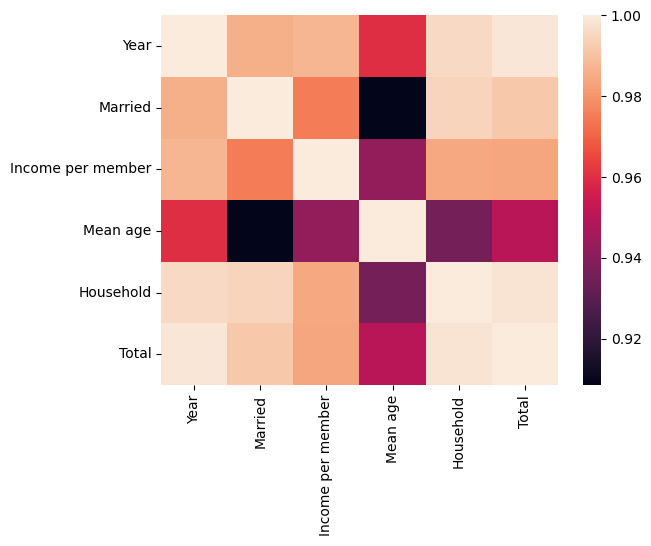

In [11]:
new = df.corr()
sns.heatmap(new)
plt.show()

In [12]:
new

,Year,Married,Income per member,Mean age,Household,Total
Year,1.000000,0.985780,0.987215,0.959830,0.995586,0.998708
Married,0.985780,1.000000,0.975002,0.908546,0.994404,0.991485
Income per member,0.987215,0.975002,1.000000,0.942462,0.984074,0.983914
Mean age,0.959830,0.908546,0.942462,1.000000,0.935904,0.950156
Household,0.995586,0.994404,0.984074,0.935904,1.000000,0.998158
Total,0.998708,0.991485,0.983914,0.950156,0.998158,1.000000


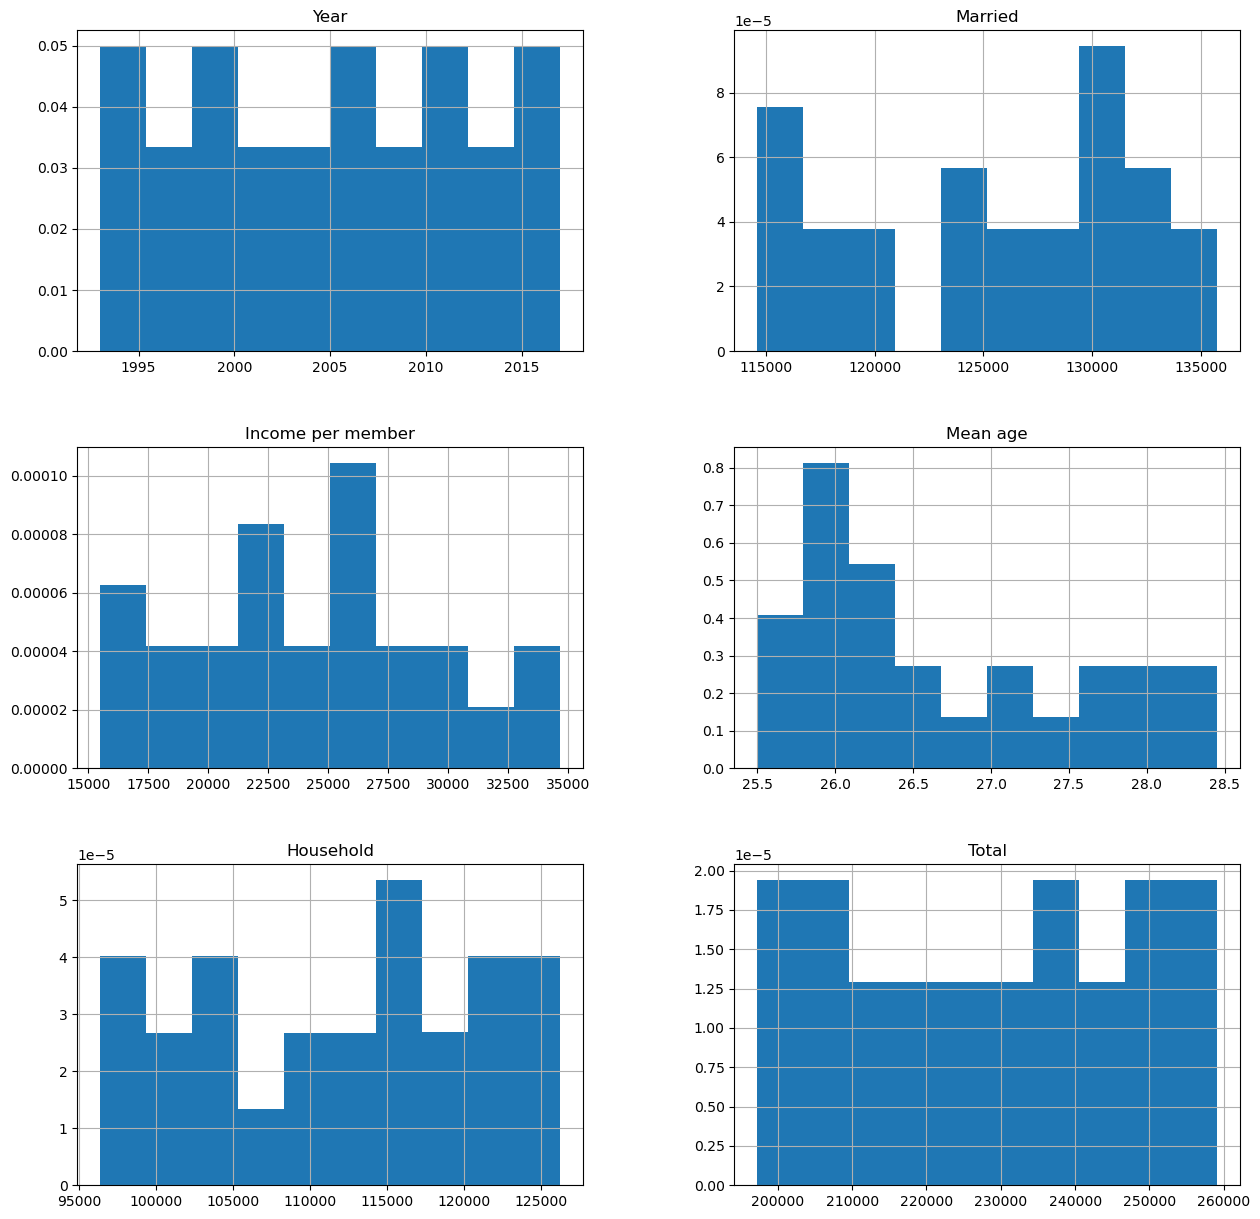

In [13]:
df.hist(figsize=(15,15), bins=10, density=True)
plt.show()

In [19]:
import warnings
import cmdstanpy
warnings.filterwarnings('ignore')
from cmdstanpy import CmdStanModel

# import arviz as az
import scipy.stats as stats


### 3. Utworzenie modeli

- Utworzyliśmy dwa modele - jeden przewidujący liczbę osób po ślubie na podstawie danych o średnim przychodzie na jednego członka gospodarstwa domowego, oraz drugi - wykorzystujący dodatkowo liczbę dostępnych miejsc zamieszkania i średni wiek wejścia w pierwszy związek małżeński,

- Zastosowaliśmy drugi predyktor z nadzieją na to że poszerzenie kontekstu poprawi otrzymywane wyniki i uczyni je bardziej zbliżonymi do rzeczwistości,

- ??????are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]

In [23]:
model_1_prior = CmdStanModel(stan_file='test_prior.stan')
model_1_posterior = CmdStanModel(stan_file='test_posterior.stan')
model_2_prior = CmdStanModel(stan_file='tri_prior_test.stan')
model_2_posterior = CmdStanModel(stan_file='tri_posterior_test.stan')

N = 25
R = 30

23:06:29 - cmdstanpy - INFO - compiling stan file C:\Users\adamz\Desktop\Data Analitics\DA_project\test_prior.stan to exe file C:\Users\adamz\Desktop\Data Analitics\DA_project\test_prior.exe


ValueError: Failed to compile Stan model 'C:\Users\adamz\Desktop\Data Analitics\DA_project\test_prior.stan'. Console:

--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/test_prior.hpp C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/test_prior.stan
Error in 'C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/test_prior.stan', line 9, column 26: fabs
    was removed in Stan 2.33. Use abs instead. This can be automatically
    changed using the canonicalize flag for stanc
make/program:48: recipe for target 'C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/test_prior.hpp' failed
mingw32-make: *** [C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/test_prior.hpp] Error 65

Command ['mingw32-make', 'C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/test_prior.exe']
	error during processing No such file or directory


### 4. Priors

- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]

Priory zostały wybrane poprzez znalezienie funkcji jak najlepiej dopasowanej do rozkładu danych na układzie współrzędnych - np. dla zależności ilości małżeństw od średniego przychodu na osobę w gospodarstwie domowym najlepszym dopasowaniem okazała się funkcja liniowa $ax +b$. Wystarczyło więc dobrać odpowiednie wartości parametrów $a$ i $b$.

#### 4.1. Model 1. 

In [ ]:
data = {'N': N, 'income': df['Income per member']}
gen_1 = model_1_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

In [ ]:
gen_1.draws_pd()

In [ ]:
for i in range(len(gen_1.y_sim)):
    plt.plot(df['Income per member'], gen_1.alpha[i]*df['Income per member'] + gen_1.beta[i], color='black', alpha = 0.1)
plt.plot(df['Income per member'], gen_1.alpha[i].mean()*df['Income per member'] + gen_1.beta.mean(), color='red')   
plt.scatter(df['Income per member'], df['Married'], color='green')
plt.show()

In [ ]:
for i in range(R):
    plt.hist(gen_1.y_sim[i], bins=5, color='green', alpha = 0.5, density=True)
plt.hist(df['Married'], bins=23, color='red', density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.show()

#### 4. 2. Model 2. 

In [ ]:
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age']}
gen_tri = model_2_prior.sample(
                    data=data,
                    iter_sampling=R,
                    iter_warmup=0,
                    chains=1,
                    fixed_param=True)

In [ ]:
gen_tri.draws_pd()

In [ ]:
for i in range(len(gen_tri.y_sim)):
    plt.scatter(df['Year'], gen_tri.y_sim[i], alpha = 0.1, color="black")
plt.scatter(df['Year'], df['Married'], label= 'True data', color="red")
plt.plot(df['Year'], -gen_tri.alpha_1.mean()*df['Income per member'] + gen_tri.alpha_2.mean()*df['Household'] - gen_tri.alpha_3.mean()*df['Mean age']+ gen_tri.beta.mean())
plt.title('Entire period')
plt.ylabel('Married')
plt.xlabel('Year')
plt.legend()
plt.show()

### 5. Posterior (model 1) - analiza

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

### 6. Posterior (model 2) - analiza

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

### 7. Porównanie modeli

- Have models been compared using information criteria [1 pt]
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]